# Chap 19 - Ex2: apply HoltWinters for bitcoin_price.csv data (close price)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [3]:
bitcoin = (
    pd.read_csv('data/bitcoin_price.csv')
    .drop(['Open', 'High', 'Low', 'Volume', 'Market Cap'], axis = 1)
    .assign(Date = lambda df: pd.to_datetime(df['Date'], yearfirst=False, dayfirst=True))
    .set_index('Date')
    .asfreq('D')
    .assign(Close=lambda df: df['Close'].fillna(df['Close'].interpolate()))
)

bitcoin

,Close
Date,
2013-04-28,134.21
2013-04-29,144.54
2013-04-30,139.00
2013-05-01,116.99
2013-05-02,105.21
...,...
2017-11-03,7207.76
2017-11-04,7379.95
2017-11-05,7407.41


## <span style = 'color:yellow'> Seasonality check

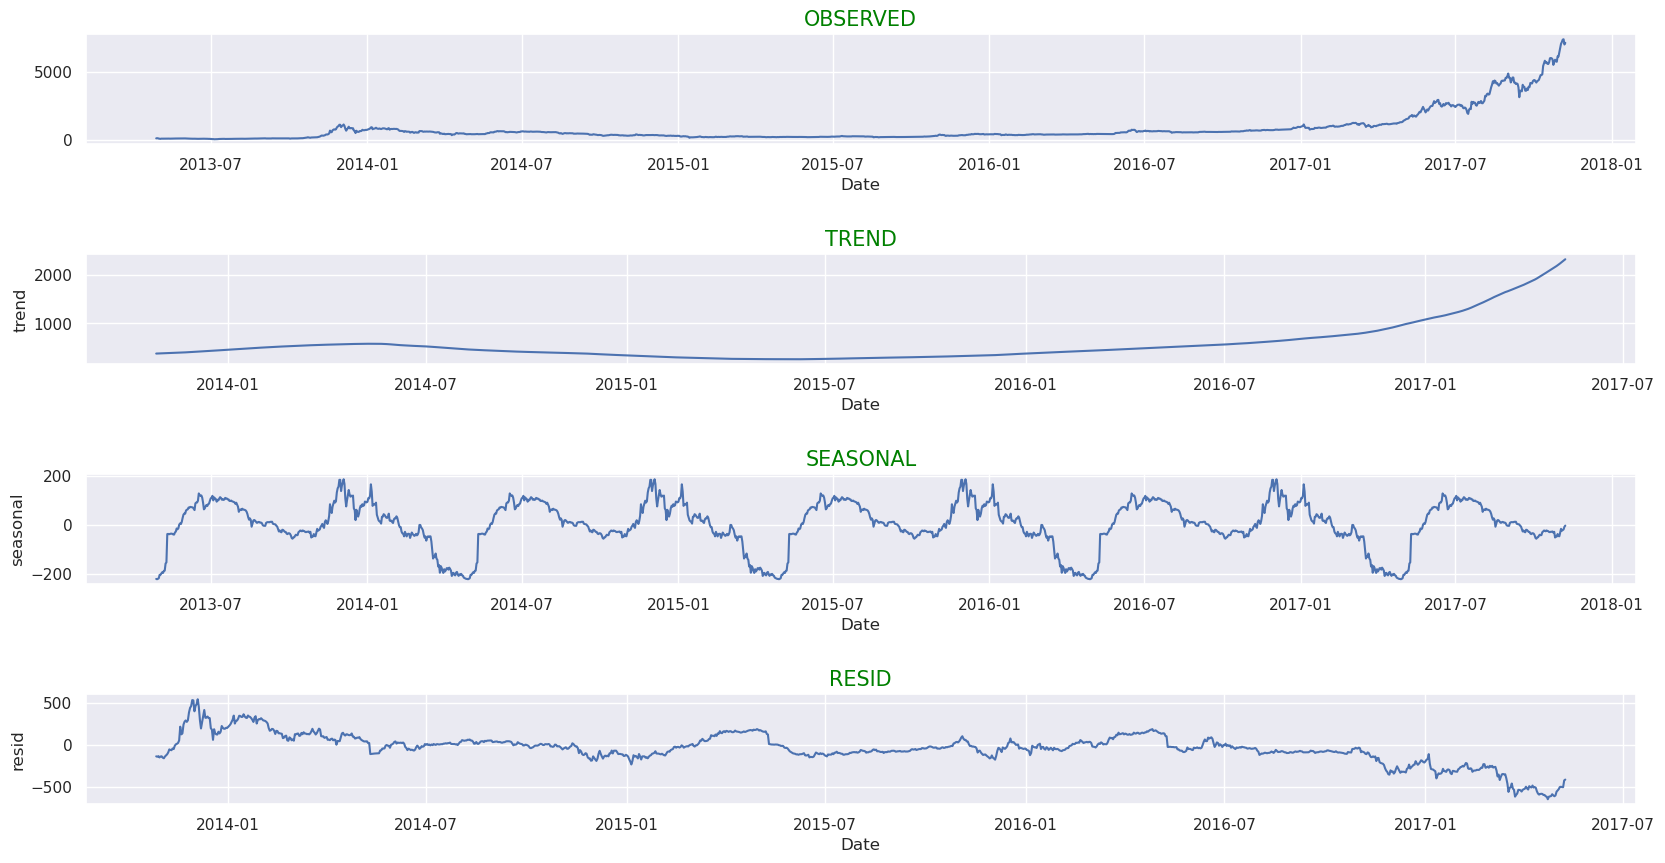

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_check = seasonal_decompose(
    bitcoin,
    model='additive', #Watch Observed data, if seasonal swings grow/shrink with the trend, use "multiplicative". If they stay constant, use "additive".
    period=365
)

attr = ['observed', 'trend', 'seasonal', 'resid']

#Draw all plots
sbn.set_theme(style='darkgrid')
plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace=1)
for i in range(len(attr)):
    plt.subplot(4,1,i+1)
    sbn.lineplot(data=getattr(seasonal_check, attr[i]))
    plt.title(attr[i].upper(), size = 15, color = 'green')
plt.show()

## <span style = 'color:yellow'> Build HoltWinters for this seasonal data

In [11]:
import pmdarima as pm
train_set, test_set = pm.model_selection.train_test_split(bitcoin, train_size=int(0.8*bitcoin.shape[0]))

from statsmodels.tsa.holtwinters import ExponentialSmoothing

holtwinters_model = ExponentialSmoothing(
                endog = train_set,
                trend = 'add',
                seasonal = 'mul',
                seasonal_periods = 7).fit()

## <span style = 'color:yellow'> Forecast

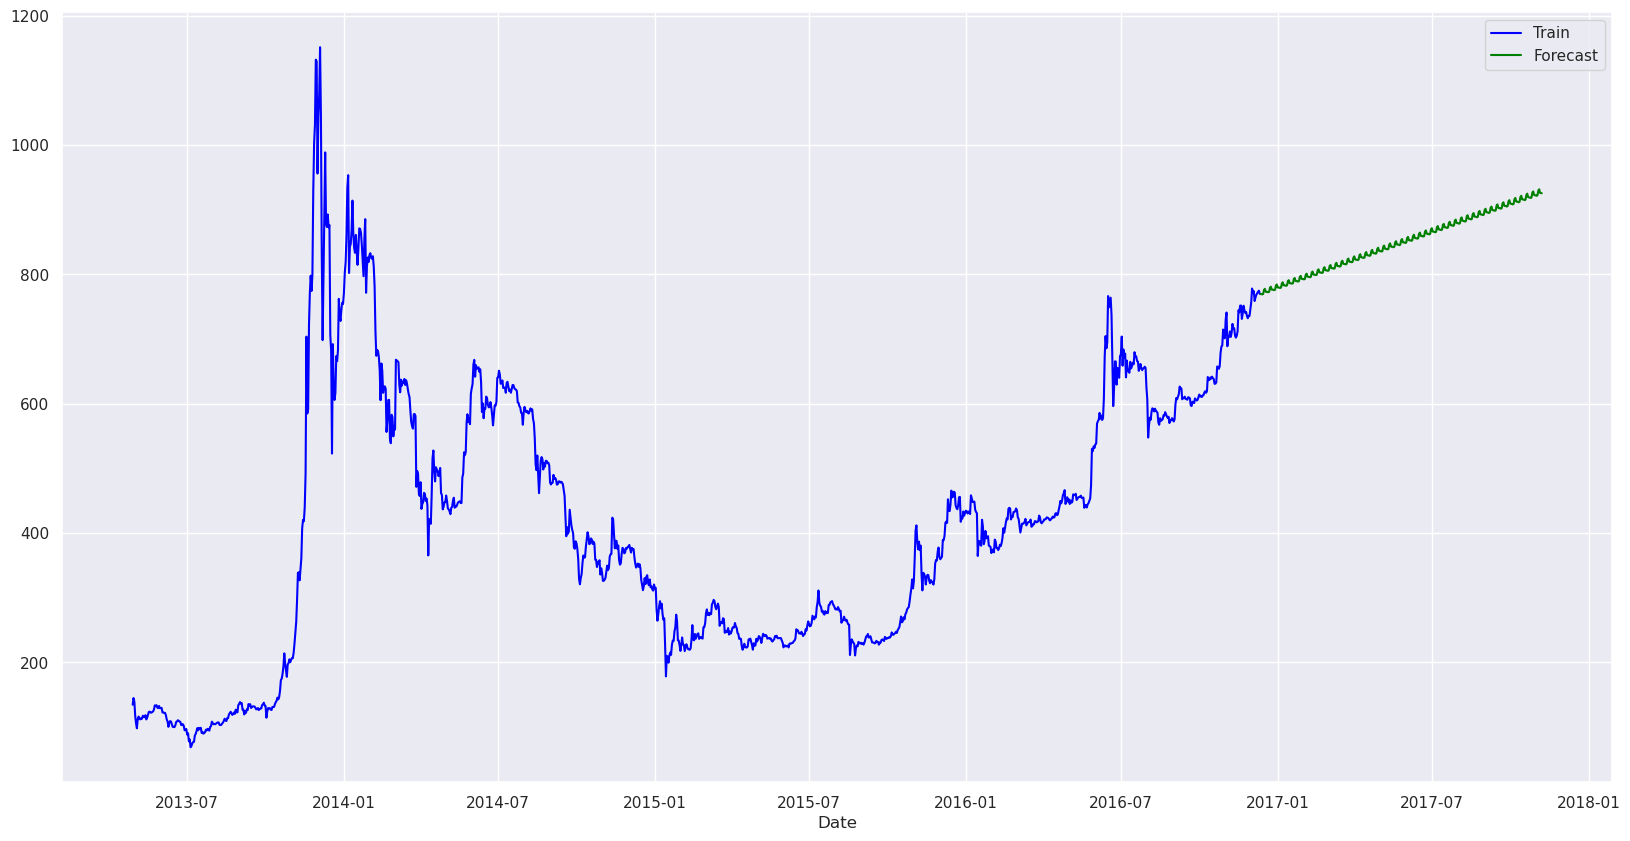

In [12]:
forecasts_test = holtwinters_model.predict(start = test_set.index[0],
                                           end = test_set.index[-1])

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(20, 10))
sbn.lineplot(x=train_set.index, y=train_set.values.ravel(), color='blue', label='Train')
sbn.lineplot(x=forecasts_test.index, y=forecasts_test.values.ravel(), color='green', label='Forecast')
plt.legend()
plt.show()

## <span style = 'color:yellow'> Evaluation

Accuracy on train set: 0.9879643040811583
Accuracy on test set: -0.9480727780264808

Mean squared error test set: 5190750.174741596
Mean absolute error test set: 1631.1784948260909



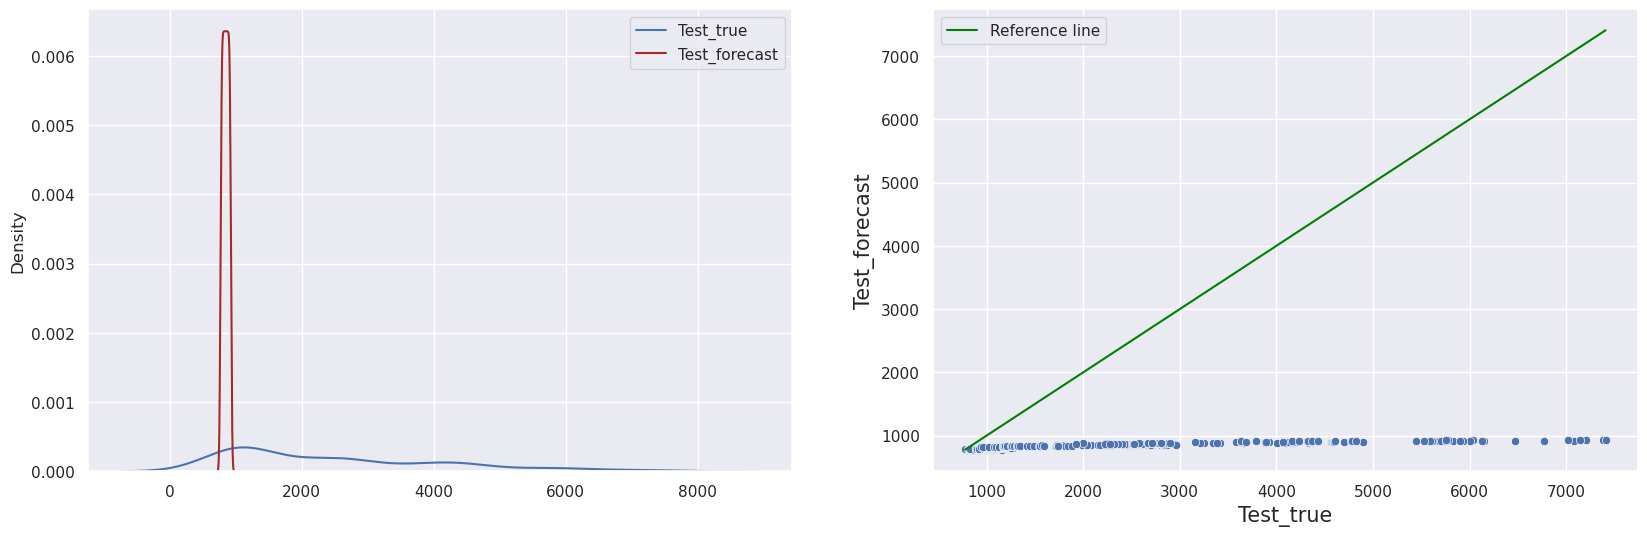

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecasts_train = holtwinters_model.predict(start = train_set.index[0],
                                           end = train_set.index[-1])

print(f'Accuracy on train set: {r2_score(train_set.values, forecasts_train.values)}')
print(f'Accuracy on test set: {r2_score(test_set.values, forecasts_test.values)}')
print()

print(f'Mean squared error test set: {mean_squared_error(test_set.values, forecasts_test.values)}')
print(f'Mean absolute error test set: {mean_absolute_error(test_set.values, forecasts_test.values)}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sbn.kdeplot(test_set.values,  label = "Test_true", color = 'green')
sbn.kdeplot(forecasts_test.values, label = "Test_forecast", color = 'brown')
plt.legend()

plt.subplot(1,2,2)
sbn.lineplot(x = [test_set.values.min(), test_set.values.max()], 
             y = [test_set.values.min(), test_set.values.max()], 
             label = 'Reference line', color = 'green')
sbn.scatterplot(x = test_set.values.ravel(), y = forecasts_test.values.ravel())
plt.xlabel("Test_true", size=15)
plt.ylabel("Test_forecast", size=15)
plt.show()